# Navnet R&D Notebook

## Prepare dataset

In [1]:
# training_dataset_root_path = "/home/michael/Desktop/BytesDB_train/"
training_dataset_root_path = "/home/michael/Desktop/BytesDB_simple2/"
validation_dataset_root_path = "/home/michael/Desktop/BytesDB_validation/"

In [15]:
import csv
import os

class BytesDataset:
    def __init__(self,  root_path):
        self.root_path = root_path
        self.dataset_left_imgs = os.path.join(self.root_path, "left")
        self.dataset_right_imgs = os.path.join(self.root_path, "right")
        self.dataset_file = os.path.join(self.root_path, "db.csv")
        self._read_db_file()
        
    def get_index_map(self):
        return self.index_map
    
    def get_left_images_path(self):
        return self.dataset_left_imgs 
    
    def get_right_images_path(self):
        return self.dataset_right_imgs 
    
    def get_db(self):
        return self.db_file
    
    def get_episode_indices(self):
        return self.episode_indicies
    
    def get_drive_command(self, row):
        return [self.get_db_value(row, 'action x'), self.get_db_value(row, 'action r')]
    
    def get_position(self, row):
        return [self.get_db_value(row, 'position x'), self.get_db_value(row, 'position y'), self.get_db_value(row, 'position z')]
    
    def get_orientation(self, row):
        return [self.get_db_value(row, 'odom orientation z'), self.get_db_value(row, 'odom orientation y'), self.get_db_value(row, 'odom orientation x'), self.get_db_value(row, 'odom orientation w')]
    
    def get_db_value(self, row, column):
        if type(column) == str:
            column = self.index_map[column]
        if column:
            return float(self.db_file[row][column])
        else: 
            return self.db_file[row][column]
    
    def _read_db_file(self):
        # Read the db file
        self.db_file = []
        # start and stops for each episode (zero to be replaced later) [inclusive, exclusive]
        self.episode_indicies = [[1,0]] 
        with open(self.dataset_file) as file:
            csv_reader = csv.reader(file)
            for i, row in enumerate(csv_reader):
                if(row[0] == "-"):
                    self.episode_indicies.append([i+1,0])
                    self.episode_indicies[len(self.episode_indicies)-2][1] = i
                self.db_file.append(row)
            if self.episode_indicies[len(self.episode_indicies)-1][1] == 0:
                self.episode_indicies[len(self.episode_indicies)-1][1] = len(self.db_file)
        self.index_map = dict(zip(self.db_file[0],range(len(self.db_file[0]))))
        
validation_data = BytesDataset(validation_dataset_root_path)
train_data = BytesDataset(training_dataset_root_path) 

print("Size of training set: ", len(train_data.get_db()))
print("Size of validation set: ", len(validation_data.get_db()))

Size of training set:  405
Size of validation set:  7910


In [3]:
print(validation_data.episode_indicies)

[[1, 32], [33, 81], [82, 264], [265, 358], [359, 379], [380, 463], [464, 580], [581, 623], [624, 653], [654, 800], [801, 955], [956, 1100], [1101, 1229], [1230, 1280], [1281, 1299], [1300, 1325], [1326, 1332], [1333, 1434], [1435, 1436], [1437, 1505], [1506, 1512], [1513, 1514], [1515, 1567], [1568, 1692], [1693, 1885], [1886, 1905], [1906, 1937], [1938, 2219], [2220, 2254], [2255, 2268], [2269, 2356], [2357, 2420], [2421, 2450], [2451, 2476], [2477, 2509], [2510, 2522], [2523, 2550], [2551, 2592], [2593, 2671], [2672, 2729], [2730, 2852], [2853, 2897], [2898, 2980], [2981, 3489], [3490, 3505], [3506, 3518], [3519, 3634], [3635, 3645], [3646, 3717], [3718, 3828], [3829, 3844], [3845, 3903], [3904, 3917], [3918, 3936], [3937, 3955], [3956, 4095], [4096, 4603], [4604, 4643], [4644, 4678], [4679, 4732], [4733, 4754], [4755, 4779], [4780, 4840], [4841, 4902], [4903, 5053], [5054, 5152], [5153, 5167], [5168, 5287], [5288, 5293], [5294, 5295], [5296, 5297], [5298, 5299], [5300, 5301], [5302,

### Add functions for reading / augmenting images

In [4]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return torch.clamp(tensor + torch.randn(tensor.size()) * self.std + self.mean, min=0, max=1.0)
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [5]:
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torchvision
import torchvision.transforms as transforms

def read_image(time_stamp, imgs_path, augment=False):
    img = plt.imread(os.path.join(imgs_path, time_stamp + ".jpg"))
    if augment:
        transform = transforms.Compose(
        [transforms.ColorJitter(0.5, 0.5, 0.5),
         transforms.RandomAffine(10, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
         transforms.ToTensor(),
         AddGaussianNoise(0, 0.01),
         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # imagenet normalization
        ]) 
    else: 
        transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # imagenet normalization
        ]) 
    img = transform(Image.fromarray(img))
    return img

image = read_image(train_data.get_db()[1][0], train_data.get_left_images_path())

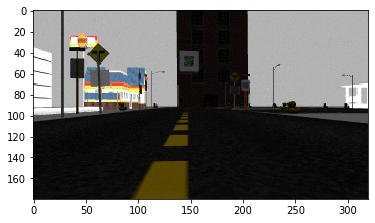

In [6]:
import numpy as np

def show_tensor_img(image):
    npimg = image.numpy().copy()
    # unnormalize the image
    npimg[0] *= 0.229
    npimg[1] *= 0.224
    npimg[2] *= 0.225
    npimg[0] += 0.485
    npimg[1] += 0.456
    npimg[2] += 0.406
    npimg = np.transpose(npimg, (1,2,0))
    return npimg

plt.imshow(show_tensor_img(image))

### Add functions for generating batches

In [23]:
import math
def kinematics_model(data, start_index, stop_index):
    # negative r is right
    path_est = []

    last_pose = [0,0,0] # x,y,yaw
    for i in range(start_index,stop_index):
        command = data.get_drive_command(i)
        dt = 0.2

        yaw = last_pose[2] + command[1]*dt
        x = last_pose[0] + command[0]*dt*math.sin(yaw)
        y = last_pose[1] + command[0]*dt*math.cos(yaw)

        last_pose = [x,y,yaw]

        path_est.append([-x,y])        
    return path_est

In [24]:
def quaternion_mult(q,r):
    return [r[0]*q[0]-r[1]*q[1]-r[2]*q[2]-r[3]*q[3],
            r[0]*q[1]+r[1]*q[0]-r[2]*q[3]+r[3]*q[2],
            r[0]*q[2]+r[1]*q[3]+r[2]*q[0]-r[3]*q[1],
            r[0]*q[3]-r[1]*q[2]+r[2]*q[1]+r[3]*q[0]]

# input point is [x,y,z] and quaternion is z, x, y, w
def point_rotation_by_quaternion(point,q):
    r = [0]+point
    q_conj = [q[0],-1*q[1],-1*q[2],-1*q[3]]
    return quaternion_mult(quaternion_mult(q,r),q_conj)[1:]

# point 1 - point 2
def subtract_points(point1, point2):
    return [point1[0] - point2[0], point1[1] - point2[1], point1[2] - point2[2]]

In [25]:
import os
images = os.listdir(training_dataset_root_path + "/right")
image_dict = {}
for image in images:
    image_dict[os.path.splitext(image)[0]] = read_image(os.path.splitext(image)[0], training_dataset_root_path + "right", augment=False)

In [26]:
import random, os

def batch_generator(dataset, collision_buffering=3, timesteps=10, batch_size=16, augmentation=False):
   
    # for getting the dimensions of the images before making the batch so that a proper array can be initialized 
    demo_image = None 
    index = 0
    
    # read in all the rigth and left images into dictionaries
    right_images_dict = {}
    images = os.listdir(dataset.get_right_images_path())
    for image in images:
        right_images_dict[os.path.splitext(image)[0]] = read_image(os.path.splitext(image)[0], dataset.get_right_images_path(), augment=augmentation)
        
    left_images_dict = {}
    images = os.listdir(dataset.get_left_images_path())
    for image in images:
        left_images_dict[os.path.splitext(image)[0]] = read_image(os.path.splitext(image)[0], dataset.get_left_images_path(), augment=augmentation)
    
    while demo_image == None and index < len(dataset.get_db()):
        try:
            demo_image = read_image(dataset.get_db_value(index, 'stamp'), dataset.get_left_images_path(), dataset.get_right_images_path())   
        except:
            demo_image = None
        index += 1
    
    while True:
        
        left_images = torch.zeros((batch_size, demo_image.shape[0], demo_image.shape[1], demo_image.shape[2]))
        right_images = torch.zeros((batch_size, demo_image.shape[0], demo_image.shape[1], demo_image.shape[2]))
        actions = torch.zeros((batch_size, timesteps, 4))
        labels = torch.zeros((batch_size, timesteps, 4))
        
        for i in range(batch_size):
            
            start = -1
            episode_num = -1
            while(start < 1):
                try:
                    episode_num = random.randint(0, len(dataset.get_episode_indices())-1)
                    start = random.randint(dataset.get_episode_indices()[episode_num][0], dataset.get_episode_indices()[episode_num][1]-timesteps-1)
                except:
                    pass
           
            # now that we have a starting index we can build oup the output sequence
            image_name = dataset.get_db()[start][0] if '.' in dataset.get_db()[start][0] else dataset.get_db()[start][0] + "."
            left_images[i]  = left_images_dict[image_name]
            right_images[i] = right_images_dict[image_name]
            
            starting_position = dataset.get_position(start)
            starting_orientation = dataset.get_orientation(start)
            
            episode_actions = []
            episode_labels = []
            kinematics_path_est = kinematics_model(dataset, start+1, start+timesteps+1)
            for t in range(1, timesteps+1):
                # convert position into robots first action reference space
                new_position = dataset.get_position(start+t)
                transformed_point = point_rotation_by_quaternion(subtract_points(starting_position, new_position), starting_orientation)
    
                episode_actions.append([dataset.get_db_value(start+t, 'action x'),dataset.get_db_value(start+t, 'action r'), \
                                        kinematics_path_est[t-1][0], kinematics_path_est[t-1][1]])
        
                # look ahead for the collision buffer
                collision = dataset.get_db_value(start+t,'collision bool')
                c = 1
                while c < collision_buffering+1 and start+t+c < dataset.get_episode_indices()[episode_num][1]:
                    if dataset.get_db_value(start+t+c,'collision bool') == True:
                        collision = True
                    c += 1

                episode_labels.append([-transformed_point[1], transformed_point[0], dataset.get_db_value(start+t, 'bumpiness score'), collision])

            actions[i] = torch.tensor(episode_actions)
            labels[i] = torch.tensor(episode_labels)
        
        yield (left_images, right_images, actions, labels)
            

In [37]:
gen = batch_generator(train_data)
left_images, right_images, actions, labels = next(gen)

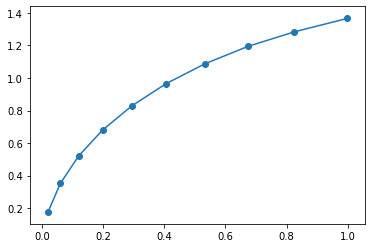

In [42]:
import matplotlib.pyplot as plt
# path computed by kinematics model
index = 10
plt.scatter(actions[index,:,2], actions[index,:,3])
plt.plot(actions[index,:,2], actions[index,:,3])
plt.show()

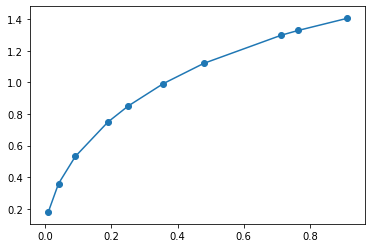

In [43]:
# path computer by ground truth
plt.scatter(labels[index,:,0], labels[index,:,1])
plt.plot(labels[index,:,0], labels[index,:,1])
plt.show()

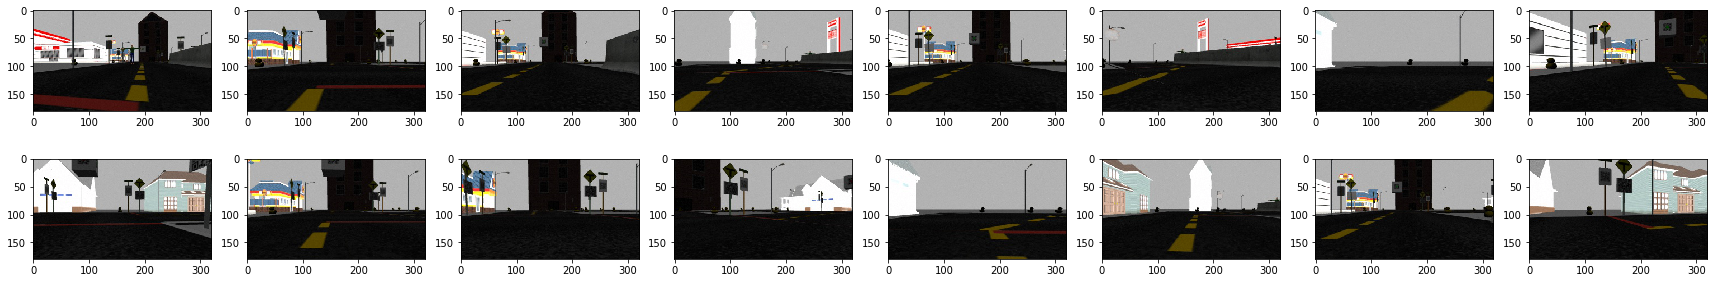

In [44]:
# Preview a batch

# Left Images
fig = plt.figure(figsize=(30,5))
for i in range(len(left_images)):
    fig.add_subplot(2, len(left_images)/2, i+1)
    plt.imshow(show_tensor_img(left_images[i]))

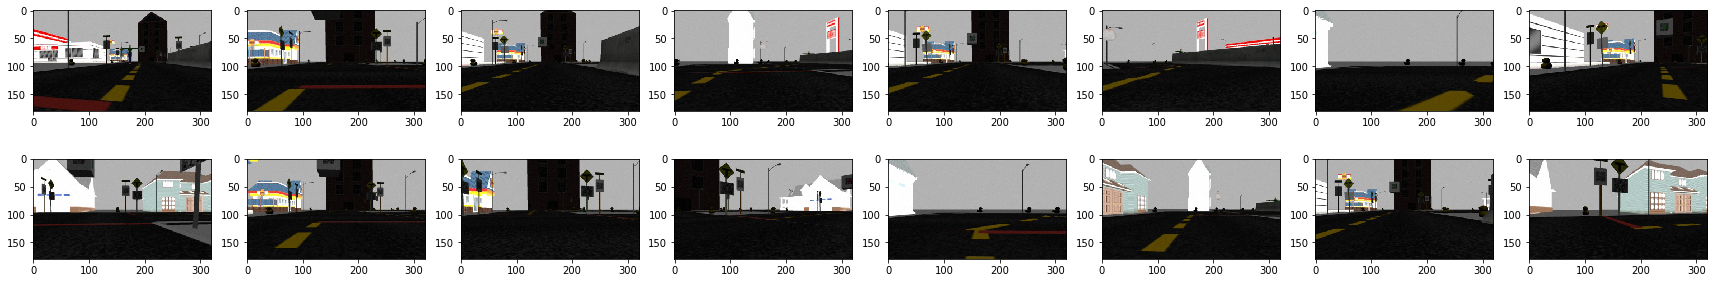

In [45]:
# Rigth Images
fig = plt.figure(figsize=(30,5))
for i in range(len(right_images)):
    fig.add_subplot(2, len(right_images)/2, i+1)
    plt.imshow(show_tensor_img(right_images[i]))

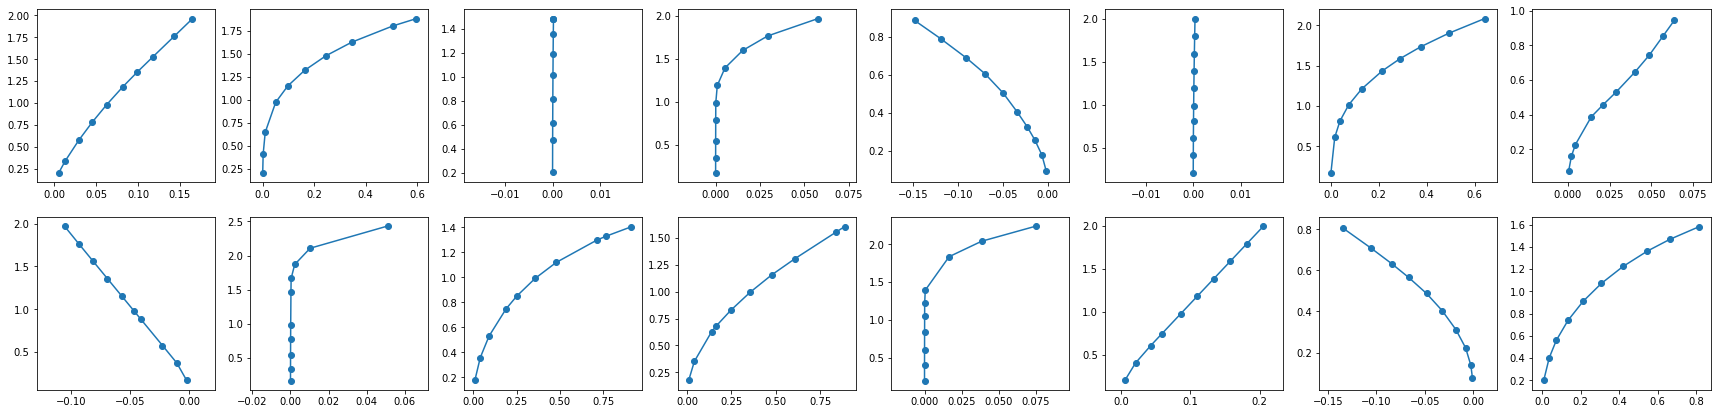

In [46]:
fig = plt.figure(figsize=(30,7))
for i in range(len(labels)):
    fig.add_subplot(2, len(labels)/2, i+1)
    
    output_w_zero = labels[i].numpy().copy()[:,:2]
    positions_as_np = np.array(output_w_zero)
    
    plt.scatter(positions_as_np[:,0], positions_as_np[:,1])
    plt.plot(positions_as_np[:,0], positions_as_np[:,1])
plt.show()

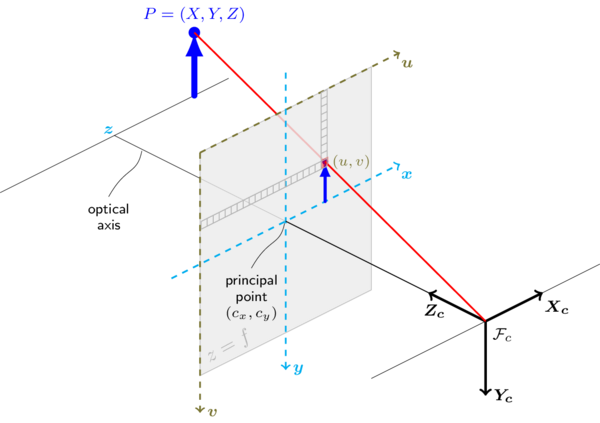

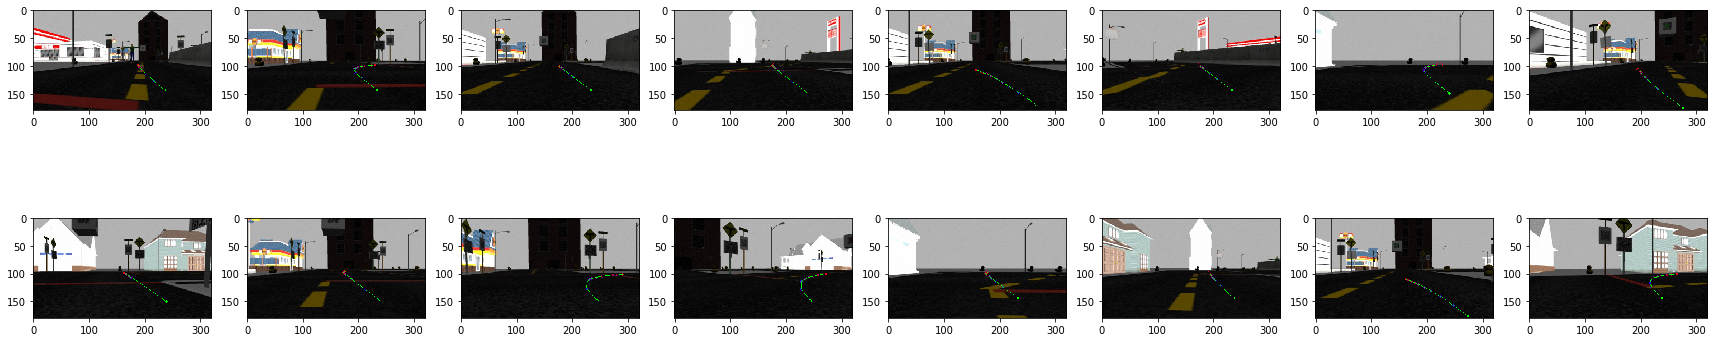

In [47]:
# Advanced visualization
import cv2
    
# camera matrix
cameraMatrix = np.float64([[190.68123344056778, 0.0, 160.5], [0.0, 190.68123344056778, 90.5], [0.0, 0.0, 1.0]]) # sim
# dist coefficients
distCoeffs = np.array([0.0, 0.0, 0.0, 0.0, 0.0]) # sim

# rotation/translaton of base_link - > camera optical link 
# 0.1485 0.1 0.1325 
# -0.5 0.5 -0.5 0.5
rvec = np.float64([-1.5707963, 1.5707963, 0 ])
tvec = np.float64([0.1485, 0.1, 0.1325])

# path to project onto image
fig = plt.figure(figsize=(30,7))
for p in range(len(labels)):
    fig.add_subplot(2, len(labels)/2, p+1)
    
    path = labels[p,:,:2].numpy().copy()
    camera_ref_path = np.zeros((len(path),3))
    for i, point in enumerate(path):
        # to coordinate system x = z, y = constant, z = x
        camera_ref_path[i] = ([point[0]+tvec[2], tvec[1], point[1]+tvec[0]])
    
    img = show_tensor_img(left_images[p]).copy()

    last_point = None
    for i, point in enumerate(camera_ref_path):
        reprojected_point = np.matmul(cameraMatrix, point)
        if(i == 0):
            cv2.circle(img, (int(reprojected_point[0]/reprojected_point[2]),int(reprojected_point[1]/reprojected_point[2])), 2, (0,1,0), 1)
            last_point = (int(reprojected_point[0]/reprojected_point[2]),int(reprojected_point[1]/reprojected_point[2]))
        else:
            cv2.circle(img, (int(reprojected_point[0]/reprojected_point[2]),int(reprojected_point[1]/reprojected_point[2])), 2, (i/len(camera_ref_path),0,1-i/len(camera_ref_path)), 1)
            cv2.line(img, last_point, (int(reprojected_point[0]/reprojected_point[2]),int(reprojected_point[1]/reprojected_point[2])), (0,1,0), 1)
            last_point = (int(reprojected_point[0]/reprojected_point[2]),int(reprojected_point[1]/reprojected_point[2]))

    plt.imshow(img)

## Construct the Simplified Model - Take in Sequence of Positions and Predict Position

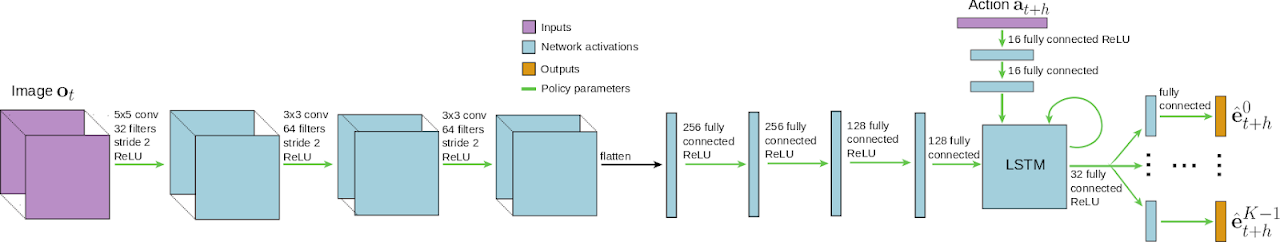

In [156]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# https://pytorch.org/docs/stable/nn.html
class NavNet(nn.Module):
    def __init__(self, hidden_dims=128, lstm_input_dims=16):
        super(NavNet, self).__init__()
        
        self.fc_in1 = nn.Linear(4, 8)
        self.fc_in2 = nn.Linear(8, lstm_input_dims)
        self.fc_in3 = nn.Linear(lstm_input_dims, lstm_input_dims)
        
        self.lstm = nn.GRU(lstm_input_dims, hidden_dims, 1, batch_first=True)
        
        self.fc1 = nn.Linear(hidden_dims, hidden_dims)
        self.fc2 = nn.Linear(hidden_dims, hidden_dims)
        self.fc3 = nn.Linear(hidden_dims, 2)
        
    # seq is the action sequence to be evaluated [[action 1],[action 2],[action 3]]
    def forward(self,seq):
        
        inp = F.dropout(F.relu(self.fc_in1(seq)), 0.0)
        inp = F.dropout(F.relu(self.fc_in2(inp)), 0.0)
        inp = self.fc_in3(inp)

        
        out, _ = self.lstm(inp)
        
        output = F.dropout(F.relu(self.fc1(out)), 0.0)
        output = F.dropout(F.relu(self.fc2(output)), 0.0)
        output = self.fc3(output)
                                
        return output

PyTorch Version:  1.5.0
Torchvision Version:  0.6.0
cuda:0


In [144]:
import torchviz
navnet = NavNet()

In [145]:
test_batch_size = 5
action_seq_length = 6

test_input = torch.rand((test_batch_size, 3,180,320))
print("Input Image : ", test_input.shape)

test_actions = torch.rand((test_batch_size, action_seq_length,4))
print("Input Actions : ", test_actions.shape)

output = navnet(test_actions)
print("Output : ", output.shape)
print(output)

torchviz.make_dot(output).render("navnet", format="png")

Input Image :  torch.Size([5, 3, 180, 320])
Input Actions :  torch.Size([5, 6, 4])
Output :  torch.Size([5, 6, 2])
tensor([[[-0.0594,  0.0682],
         [-0.0616,  0.0677],
         [-0.0629,  0.0676],
         [-0.0636,  0.0674],
         [-0.0641,  0.0675],
         [-0.0644,  0.0674]],

        [[-0.0592,  0.0683],
         [-0.0615,  0.0676],
         [-0.0627,  0.0673],
         [-0.0636,  0.0672],
         [-0.0640,  0.0670],
         [-0.0641,  0.0669]],

        [[-0.0597,  0.0685],
         [-0.0618,  0.0677],
         [-0.0630,  0.0675],
         [-0.0637,  0.0673],
         [-0.0639,  0.0671],
         [-0.0639,  0.0670]],

        [[-0.0594,  0.0683],
         [-0.0613,  0.0676],
         [-0.0626,  0.0674],
         [-0.0636,  0.0672],
         [-0.0639,  0.0671],
         [-0.0639,  0.0670]],

        [[-0.0596,  0.0683],
         [-0.0617,  0.0676],
         [-0.0628,  0.0675],
         [-0.0638,  0.0674],
         [-0.0642,  0.0673],
         [-0.0643,  0.0672]]], grad_

'navnet.png'

In [146]:
import random, math
def fake_batch_generator(batch_size=8, seq_length=5):
    time_step = 0.5
    # r = 0
    # x = forward velocity
    while True:
        values = torch.zeros((batch_size, seq_length, 2))
        labels = torch.zeros((batch_size, seq_length, 2))
        for i in range(batch_size):
            last_y = 0
            for s in range(seq_length):
                values[i,s,0] = 0
                values[i,s,1] = random.random() 

                labels[i,s,0] = 0
                labels[i,s,1] = last_y + time_step*values[i,s,1]
        yield values, labels

## Training the model

In [147]:
from sklearn.metrics import accuracy_score

num_epochs = 60
steps_per_epoch = 50
batch_size = 32
collision_buffering = 3

timesteps = 7

train_generator = batch_generator(train_data, collision_buffering=collision_buffering, timesteps=timesteps, batch_size=batch_size, augmentation=False)

# train_generator = fake_batch_generator()

navnet = NavNet().to(device)
pytorch_total_params = sum(p.numel() for p in navnet.parameters())
print("Model Size: ", pytorch_total_params)

optimizer = optim.Adam(navnet.parameters(), lr=1e-4)
criterion = nn.MSELoss()
# criterion = nn.SmoothL1Loss()

train_loss = []
train_collision_acc = []
train_bumpiness_error = []
train_position_error = []

for e in range(num_epochs):
    # train
    avg_loss = 0
    avg_collision_acc = 0
    avg_bumpiness_error = 0
    avg_position_error = 0
    for s in range(steps_per_epoch):
        optimizer.zero_grad()

        left_images, right_images, actions, labels = next(train_generator)
        
#         print("##############################")
#         print(actions[0])
#         print(labels[0,:,:2])
#         plt.scatter(labels[0,:,0], labels[0,:,1])
#         plt.show()
#         print("##############################")

#         actions, labels = next(train_generator)
                
        output = navnet(actions.to(device))
                
        loss = criterion(output, labels[:,:,:2].to(device))
#         loss = criterion(output, labels.to(device))
        
        loss.backward()
        optimizer.step()
        
        position_error = np.linalg.norm(labels.cpu().numpy()[:,:,:2] - output.cpu().detach().numpy()[:,:,:2])
#         position_error = np.linalg.norm(labels.cpu().numpy()[:,:] - output.cpu().detach().numpy()[:,:])

        
        avg_loss += loss.item()
        avg_position_error += position_error
        
    avg_loss /= steps_per_epoch
    avg_position_error /= steps_per_epoch
    
    train_loss.append(avg_loss)
    train_position_error.append(avg_position_error)
        
        
    print('Training epoch: %d, loss: %.3f, position error: %.3f' % (e, avg_loss, avg_position_error))

    
print('Finished Training')

Model Size:  89802
Training epoch: 0, loss: 0.331, position error: 12.163
Training epoch: 1, loss: 0.201, position error: 9.357
Training epoch: 2, loss: 0.052, position error: 4.803
Training epoch: 3, loss: 0.043, position error: 4.341
Training epoch: 4, loss: 0.040, position error: 4.173
Training epoch: 5, loss: 0.040, position error: 4.163
Training epoch: 6, loss: 0.039, position error: 4.116
Training epoch: 7, loss: 0.032, position error: 3.745
Training epoch: 8, loss: 0.028, position error: 3.500
Training epoch: 9, loss: 0.024, position error: 3.250
Training epoch: 10, loss: 0.017, position error: 2.713
Training epoch: 11, loss: 0.012, position error: 2.314
Training epoch: 12, loss: 0.010, position error: 2.061
Training epoch: 13, loss: 0.009, position error: 1.982
Training epoch: 14, loss: 0.008, position error: 1.924
Training epoch: 15, loss: 0.008, position error: 1.892
Training epoch: 16, loss: 0.008, position error: 1.855
Training epoch: 17, loss: 0.008, position error: 1.862


Loss : collision acc : bumpiness l2 error : position l2 error


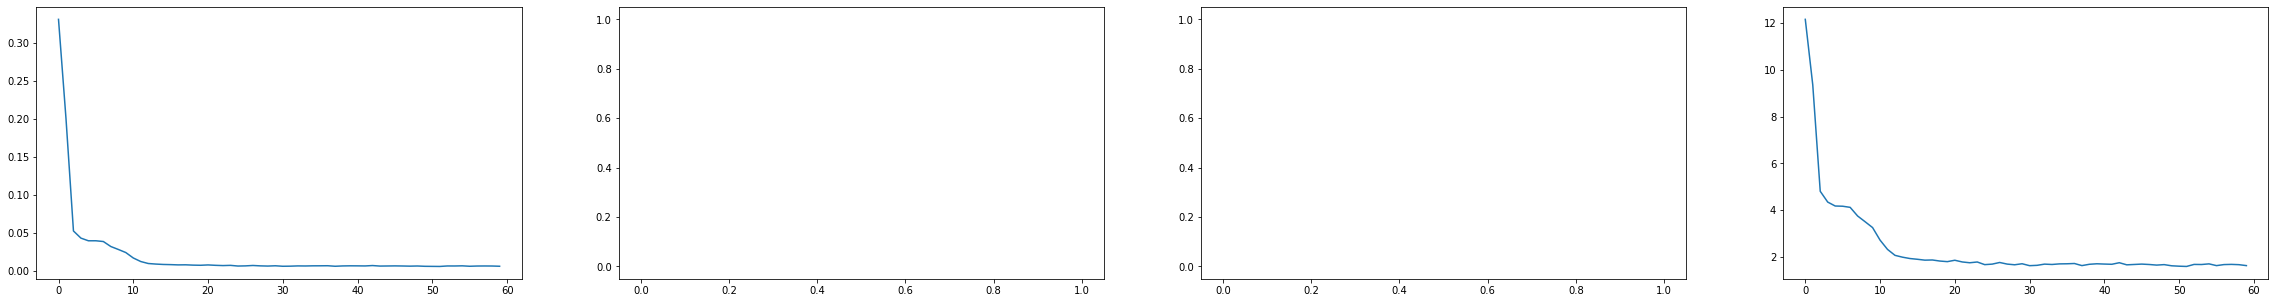

In [148]:
# Training Stats

fig = plt.figure(figsize=(40,5))
fig.add_subplot(1,4,1)
plt.plot(train_loss)
fig.add_subplot(1,4,2)
plt.plot(train_collision_acc)
fig.add_subplot(1,4,3)
plt.plot(train_bumpiness_error)
fig.add_subplot(1,4,4)
plt.plot(train_position_error)

print("Loss : collision acc : bumpiness l2 error : position l2 error")

## Test the model

In [149]:
def visualize_output(image, actions, model_output, camera_matrix=np.float64([[190.68123344056778, 0.0, 160.5], [0.0, 190.68123344056778, 90.5], [0.0, 0.0, 1.0]]), 
                     tvec=np.float64([0.1485, 0.1, 0.1325]), rvec=np.float64([-1.5707963, 1.5707963, 0 ])):
    
    fig = plt.figure(figsize=(30,5))
    
    steps = model_output
    camera_ref_path = []
    for step in steps:
        # to coordinate system x = z, y = constant, z = x
        camera_ref_path.append([step[0].item()+tvec[2], tvec[1], step[1].item()+tvec[0]])
        
    img = show_tensor_img(image).copy()
    collisions = show_tensor_img(image).copy()
    bumpiness = show_tensor_img(image).copy()

    last_point = None
    for i, point in enumerate(camera_ref_path):
        reprojected_point = np.matmul(cameraMatrix, np.float64(point))
        if(i == 0):
            cv2.circle(img, (int(reprojected_point[0]/reprojected_point[2]),int(reprojected_point[1]/reprojected_point[2])), 2, (0,1,0), 1)
            cv2.circle(collisions, (int(reprojected_point[0]/reprojected_point[2]),int(reprojected_point[1]/reprojected_point[2])), 2, (0,1,0), 1)
            cv2.circle(bumpiness, (int(reprojected_point[0]/reprojected_point[2]),int(reprojected_point[1]/reprojected_point[2])), 2, (0,1,0), 1)
            last_point = (int(reprojected_point[0]/reprojected_point[2]),int(reprojected_point[1]/reprojected_point[2]))
        else:
            new_point = (int(reprojected_point[0]/reprojected_point[2]),int(reprojected_point[1]/reprojected_point[2]))
            
            cv2.circle(img, new_point, 2, (i/len(camera_ref_path),0,1-i/len(camera_ref_path)), 1)
            cv2.line(img, last_point, new_point, (0,1,0), 1)
            
#             cv2.circle(collisions, new_point, 2, (min(max(model_output[i][3].item(),0),1),0,1-min(max(model_output[i][3].item(),0),1)), 1)
#             cv2.line(collisions, last_point, new_point, (0,1,0), 1)
            
#             cv2.circle(bumpiness, new_point, 2, (min(max(model_output[i][2].item()*20,0),1),0,1-min(max(model_output[i][2].item()*20,0),1)), 1)
#             cv2.line(bumpiness, last_point, new_point, (0,1,0), 1)
            
            last_point = new_point
    
    print("Path plot : Path plot on image : Collision : Bumpiness : Steering")

    model_output_npy = model_output.cpu().detach().numpy()
    
    fig.add_subplot(1, 5, 1)
    plt.scatter(model_output_npy[:,0], model_output_npy[:,1])
    plt.plot(model_output_npy[:,0], model_output_npy[:,1])
    
    fig.add_subplot(1, 5, 2)
    plt.imshow(img)
    
    fig.add_subplot(1, 5, 3)
    plt.imshow(collisions)
    
    fig.add_subplot(1, 5, 4)
    plt.imshow(bumpiness)
    
    fig.add_subplot(1, 5, 5)
    plt.bar(np.arange(len(actions)), np.array(actions)[:,1])

In [150]:
def label_to_output(label, index):
    return torch.cat((torch.tensor(label[2][index], dtype=torch.float32).unsqueeze(1),torch.tensor(label[1][index]).unsqueeze(1),torch.tensor(label[0][index])), axis=1)

### Eval model

In [151]:
train_generator = batch_generator(train_data, collision_buffering=collision_buffering, timesteps=timesteps, batch_size=16, augmentation=False)
left_image, right_image, actions, labels = next(train_generator)

# left_image, right_image, actions, labels = next(train_generator)
print("Input image size : ", left_image.shape)
print("Input actions size : ", actions.shape)

Input image size :  torch.Size([16, 3, 180, 320])
Input actions size :  torch.Size([16, 7, 4])


Path plot : Path plot on image : Collision : Bumpiness : Steering


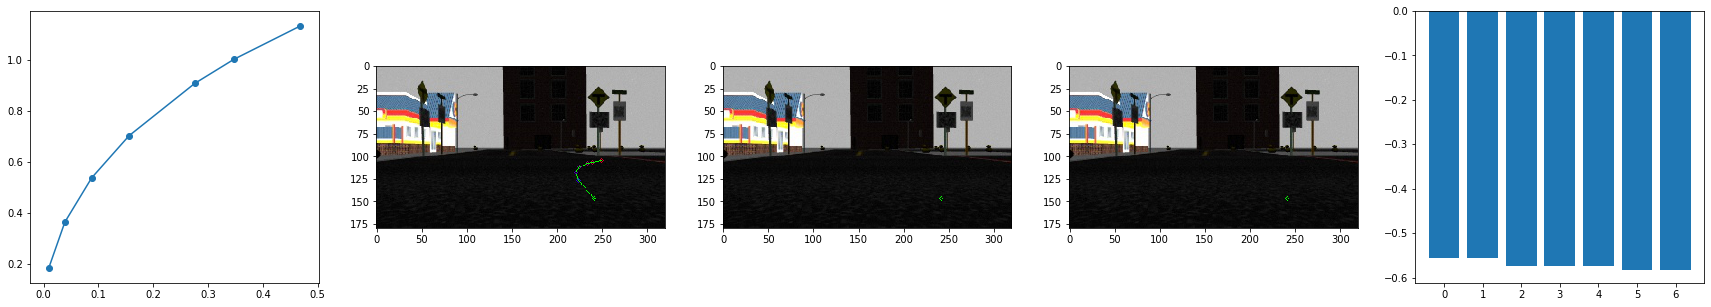

In [152]:
test_index = 12
visualize_output(left_image[test_index], actions[test_index], labels[test_index])

torch.Size([16, 7, 2])
Path plot : Path plot on image : Collision : Bumpiness : Steering


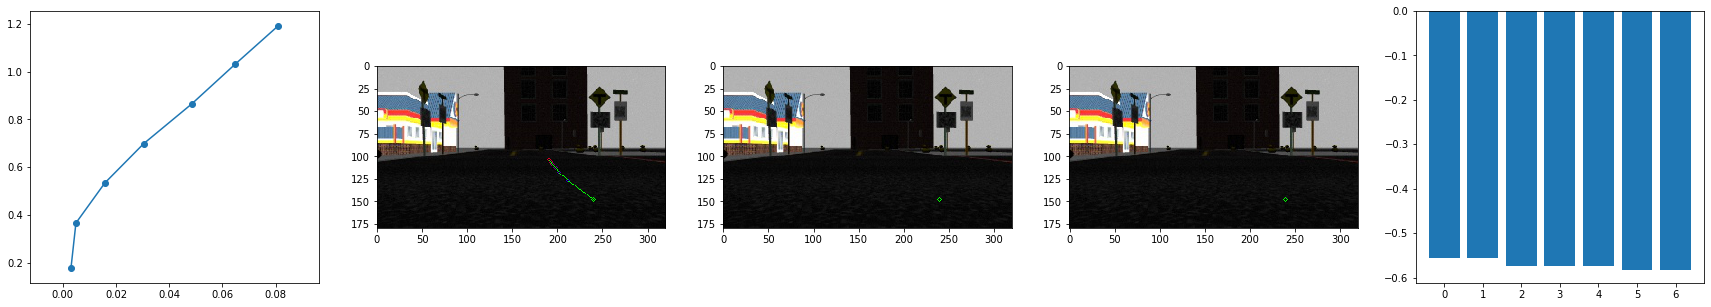

In [153]:
navnet.eval().to(device)

output = navnet(actions.to(device))
print(output.shape)
visualize_output(left_image[test_index], actions[test_index], output[test_index])

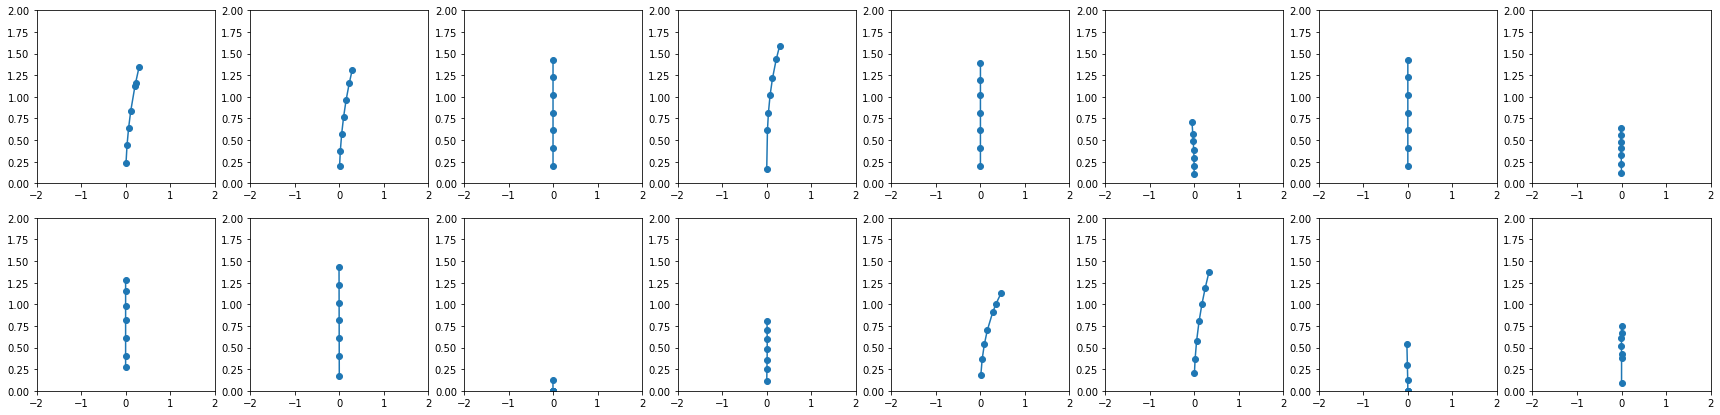

In [154]:
scale_factor = 2.0


fig = plt.figure(figsize=(30,7))
for i in range(len(labels)):
    fig.add_subplot(2, len(labels)/2, i+1)
    
    output_w_zero = labels[i].numpy().copy()[:,:2]
    positions_as_np = np.array(output_w_zero)
    
    plt.scatter(positions_as_np[:,0], positions_as_np[:,1])
    plt.plot(positions_as_np[:,0], positions_as_np[:,1])
    
    plt.xlim(-1 * scale_factor, 1 * scale_factor)
    plt.ylim(0 * scale_factor, 1 * scale_factor)
    
plt.show()

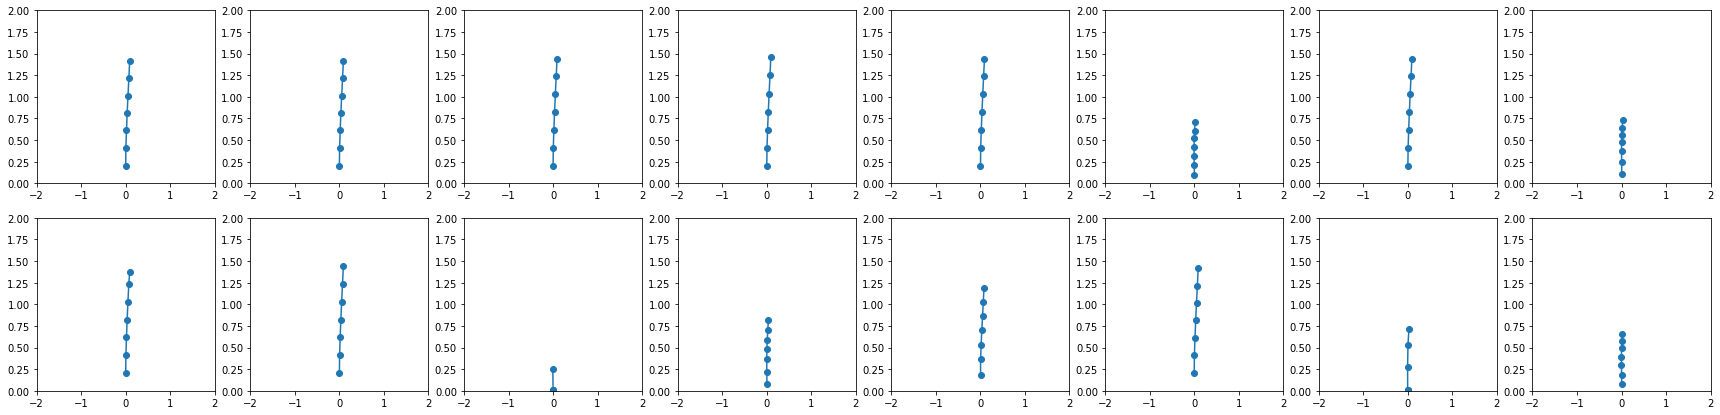

In [155]:
fig = plt.figure(figsize=(30,7))
for i in range(len(output)):
    fig.add_subplot(2, len(output)/2, i+1)
        
    output_w_zero = output[i].cpu().detach().numpy().copy()[:,:2]
    positions_as_np = np.array(output_w_zero)
    
    plt.scatter(positions_as_np[:,0], positions_as_np[:,1])
    plt.plot(positions_as_np[:,0], positions_as_np[:,1])
    
    plt.xlim(-1 * scale_factor, 1 * scale_factor)
    plt.ylim(0 * scale_factor, 1 * scale_factor)

plt.show()